In [1]:
using OrdinaryDiffEq, ParameterizedFunctions
using Optim, LsqFit 
using Plots, LaTeXStrings
using DelimitedFiles, DataFrames
using Statistics
using Printf

In [2]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [3]:
include("VirusLoadCurve.jl")
using .VirusLoadCurve

In [4]:
io = IOBuffer(append=true)
print(io, @sprintf "\nData & \$\\mx\$ & \$\\mn\$ & \$a_1\$ & \$a_2\$ & \$\\alpha\$ & \$b_1\$ & \$b_2\$ \\\\ \n")
function VLFResultsLatex(dataname, result)
    print(io, @sprintf "%s & " dataname)
    print(io, @sprintf "%.2f \$\\cdot 10^{%d}\$ & " 10^rem(result.fit.param[6], 1) floor(result.fit.param[6]))
    print(io, @sprintf "\$10^{-7}\$ & ")
    print(io, @sprintf "%.2f & " result.fit.param[1])
    print(io, @sprintf "%.2f & " result.fit.param[2])
    print(io, @sprintf "%.2f & " result.fit.param[5])
    print(io, @sprintf "%.2f & " result.fit.param[3])
    print(io, @sprintf "%.2f \\\\ \n" result.fit.param[4])
end

VLFResultsLatex (generic function with 1 method)

# Viral load data fitting

Human SARS-Cov2 data from

*To, K. K. W., Tsang, O. T. Y., Leung, W. S., Tam, A. R., Wu, T. C., Lung, D. C., Yip, C. C. Y., Cai, J. P., Chan, J. M. C., Chik, T. S. H., Lau, D. P. L., Choi, C. Y. C., Chen, L. L., Chan, W. M., Chan, K. H., Ip, J. D., Ng, A. C. K., Poon, R. W. S., Luo, C. T., … Yuen, K. Y. (2020). Temporal profiles of viral load in posterior oropharyngeal saliva samples and serum antibody responses during infection by SARS-CoV-2: an observational cohort study. The Lancet Infectious Diseases, 20(5), 565–574. https://doi.org/10.1016/S1473-3099(20)30196-1*


## Data set

23 individuals with up to 10 observations.

In [5]:
RAWDATA = readdlm("../../data/To2020/Figure_2_Viral_Load.csv", ',', Any, '\n', header=true)[1]
COLS = readdlm("../../data/To2020/Figure_2_Viral_Load.csv", ',', Any, '\n', header=true)[2]
DataFrame(RAWDATA)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,0,,,,,,,,,,,,,
2,1,5.21924,,,,,,,,,,,,
3,2,,,,,,,,8.42034,,,3.76403,,4.30903
4,3,4.77062,,,,,,,6.05675,,,,,
5,4,,,8.63656,,,,,6.21165,4.85564,6.04999,,,3.77379
6,5,,7.38193,,,6.6963,,,7.11621,6.68878,1,,,
7,6,1,7.35384,,,,,7.04338,1,,,,,
8,7,5.29376,,,,,,,4.7673,,,,,
9,8,1,,7.85297,8.4431,,,6.96152,5.14451,,,,,


In [6]:
DATA = copy(RAWDATA)
DATA[DATA .== ""] .= missing;

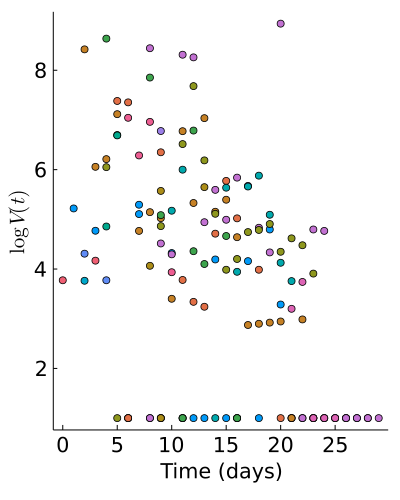

In [7]:
plt = plot(legend=:none, grid=:none, 
    xaxis=("Time (days)", font(14)), yaxis=(L"\log\,V(t)", font(14)), size=(400, 500), )
tdata = Float64.(DATA[:, 1])
[plot!(tdata, DATA[:, i], seriestype=:scatter) for i in 2:size(DATA, 2)]
savefig(figdir*"To2020Data.pdf")
display(plt)

Data points are all over the place.

### Average of data set


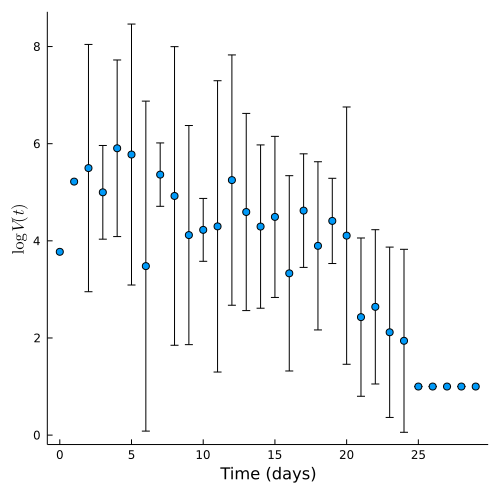

In [8]:
tdata = Float64.(DATA[:, 1])
vdata = [mean(skipmissing(DATA[i, 2:end])) for i in 1:size(DATA, 1)]
vstd = [std(skipmissing(DATA[i, 2:end])) for i in 1:size(DATA, 1)]
vcount = [count(DATA[i, 2:end] .!== missing) for i in 1:size(DATA, 1)]
plot(tdata, vdata, yerrors=vstd,
    seriestype=:scatter, legend=:none, grid=:none, size=(500, 500), 
    xlabel="Time (days)", ylabel=L"\log\,V(t)")
plot!()

Although the average data looks better, it doesn't really make sense to average the virus load per day since the each indivudual responds differently to the virus. This is way the standard deviation is large.

## Fitting the standard virus load function to each individual

Consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

In [9]:
DATA[[7,9, 10, 12, 13, 14, 16, 17, 19], 2] .= missing
DATA[[22, 23], 5] .= missing
DATA[[7, 22], 9] .= missing
DATA[[6, ], 11] .= missing
DATA[[25, 26], 16] .= missing
DATA[[17, ], 17] .= missing
DATA[[7, ], 19] .= missing
DATA[[12, ], 20] .= missing
DATA[[9, 10], 21] .= missing
DATA[[1, 30], 2:end] .= 1.;

Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:42
Finding possible parameter values 100%|█████████████████| Time: 0:00:10


Number of possible parameter found: 32922

Subject no.: 1
RSS = 8.71646e+00
a₁ = 0.0, CI=

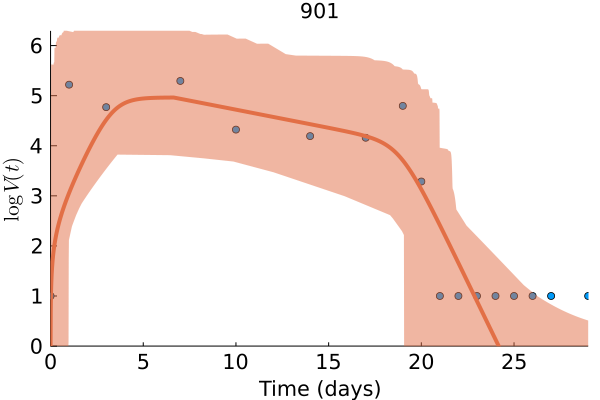

(1.482884882913459e-6, 1.7334576624977822)
a₂ = 6.642000539048579, CI=(0.02668701967323539, 13.276003498506421)
b₁ = 15.071393631331786, CI=(4.792821906772113, 21.711966638855735)
b₂ = 22.600068589805446, CI=(19.063615638826292, 28.901432081640532)
α = 0.16665310445511167, CI=(1.6408457924721453e-5, 0.5280560587813852)
logVmax = 4.9646295226799895, CI=(3.8356083514738692, 6.524368894589596)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:32
Finding possible parameter values 100%|█████████████████| Time: 0:00:10


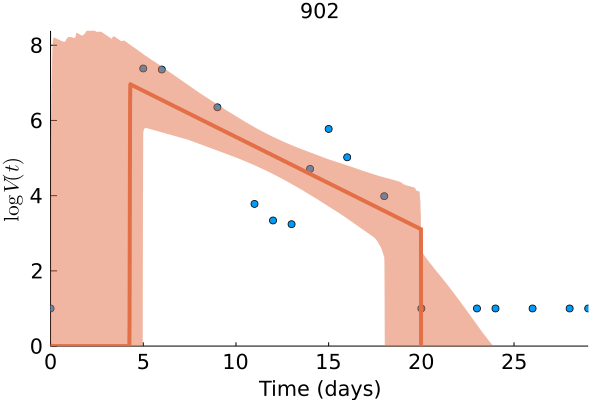

Number of possible parameter found: 32167

Subject no.: 2
RSS = 1.22739e+01
a₁ = 4.278798452595362, CI=(3.193892440656043e-5, 4.985653732677561)
a₂ = 4.304253065807361, CI=(0.1280608365432876, 7.710843799382624)
b₁ = 19.981971578857575, CI=(10.238727083076418, 19.990578280180426)
b₂ = 19.981971578857575, CI=(18.025323119307256, 26.800216491567525)
α = 0.5659784783436419, CI=(0.2889514113557075, 0.8492900913271049)
logVmax = 6.960790698929331, CI=(5.8415096105054385, 8.418516689958146)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:35
Finding possible parameter values 100%|█████████████████| Time: 0:00:11


Number of possible parameter found: 60307

Subject no.: 4
RSS = 3.69443e+01


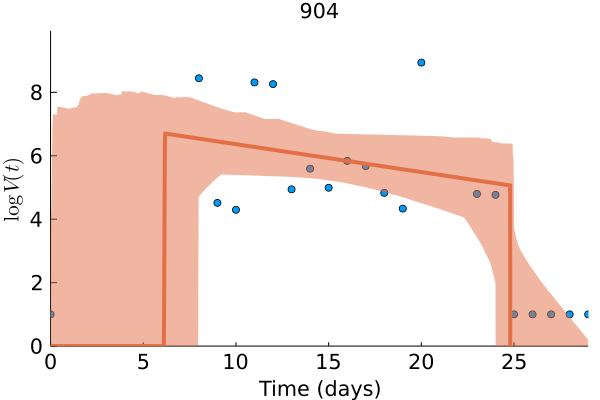

a₁ = 6.1477796903251445, CI=(6.532197842368248e-5, 7.983351625429227)
a₂ = 6.1885614501441415, CI=(0.11570835368076349, 18.287126882432197)
b₁ = 24.795250320541644, CI=(15.991525816922033, 24.995845461887995)
b₂ = 24.795250320541644, CI=(23.056547820575314, 26.544655559866744)
α = 0.20248513463382814, CI=(1.4515233952849815e-5, 0.5379003517455593)
logVmax = 6.700409353424056, CI=(5.426375572929551, 8.046227070152469)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:11
Finding possible parameter values 100%|█████████████████| Time: 0:00:07


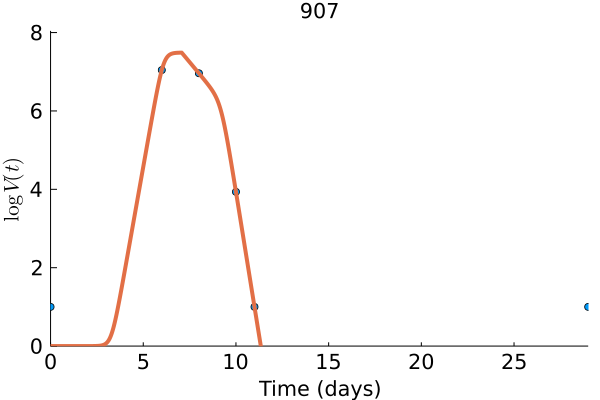

Number of possible parameter found: 0

Subject no.: 7
RSS = 1.59744e-29
a₁ = 5.116249831171849, CI=(-Inf, Inf)
a₂ = 7.073320383769631, CI=(-Inf, Inf)
b₁ = 8.108539929709934, CI=(-Inf, Inf)
b₂ = 10.303924348903335, CI=(-Inf, Inf)
α = 1.3084278717519586, CI=(-Inf, Inf)
logVmax = 7.488697253208251, CI=(-Inf, Inf)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:22
Finding possible parameter values 100%|█████████████████| Time: 0:00:11


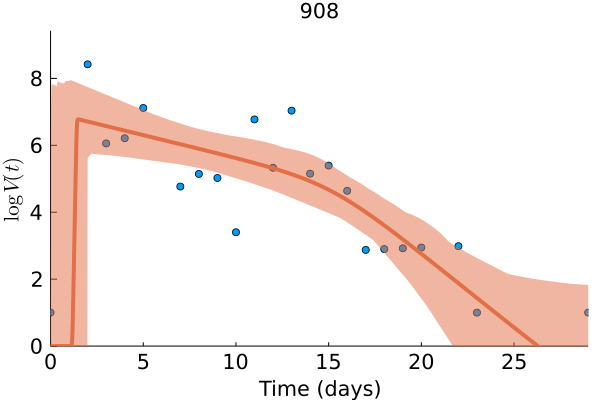

Number of possible parameter found: 56820

Subject no.: 8
RSS = 2.07736e+01
a₁ = 1.320829362138607, CI=(3.273343353238367e-5, 1.9955314264377721)
a₂ = 1.5049360555807645, CI=(0.015535628561419434, 4.945289676299177)
b₁ = 6.716273413578801, CI=(0.3458944445546184, 17.969580581942267)
b₂ = 23.55539839050053, CI=(17.578759160518082, 28.999396682789637)
α = 0.31141446438867043, CI=(0.03838507625002291, 0.5738899259508015)
logVmax = 6.777581456556533, CI=(5.794255811478244, 7.947342550902705)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:48
Finding possible parameter values 100%|█████████████████| Time: 0:00:09


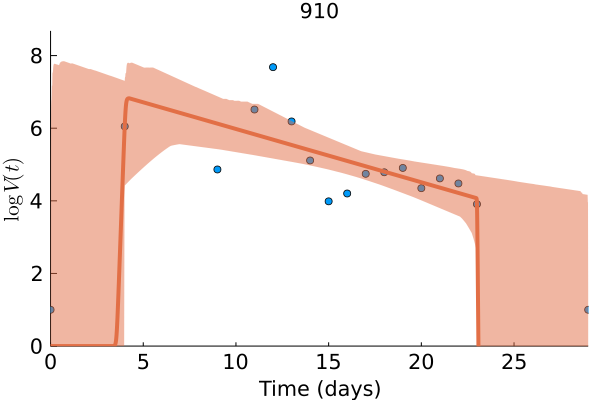

Number of possible parameter found: 78969

Subject no.: 10
RSS = 9.19081e+00
a₁ = 3.8622553072783696, CI=(0.0003910631973922385, 3.991637964566015)
a₂ = 4.237997242032917, CI=(0.026974055687779774, 12.785058063360658)
b₁ = 22.959141587754562, CI=(12.21848880304726, 28.99993390671903)
b₂ = 23.05326592747937, CI=(23.001881124159407, 28.99995972170371)
α = 0.3380340486451968, CI=(0.11304510129264786, 0.6031073270448117)
logVmax = 6.825043570509062, CI=(5.63695339649914, 7.847146477426076)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:12
Finding possible parameter values 100%|█████████████████| Time: 0:00:07


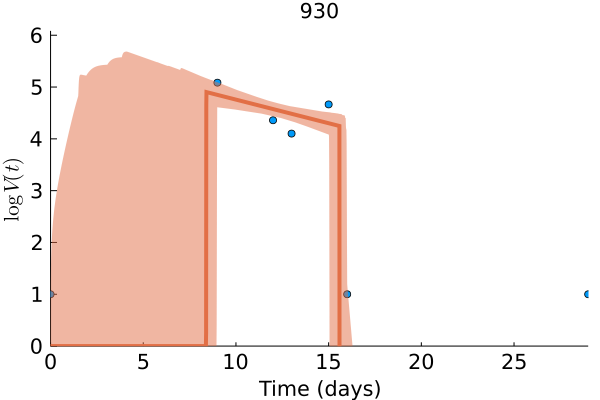

Number of possible parameter found: 910

Subject no.: 19
RSS = 3.80628e-01
a₁ = 8.394678851680947, CI=(0.08641765501725018, 8.971210442929547)
a₂ = 8.404821662987844, CI=(1.6324959423790215, 10.14813936953264)
b₁ = 15.588110062914637, CI=(14.558765893909616, 15.95517720435882)
b₂ = 15.588110062914637, CI=(15.041328911671119, 15.993196732453873)
α = 0.21000371207876578, CI=(0.06561222692250701, 0.355223956508844)
logVmax = 4.902933293023463, CI=(4.619657272901326, 5.686348186496656)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:14
Finding possible parameter values 100%|█████████████████| Time: 0:00:08


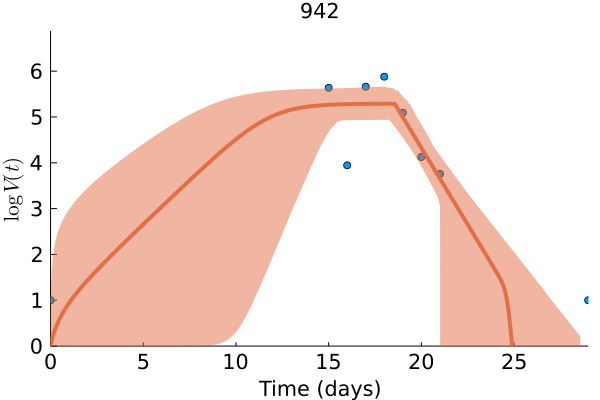

Number of possible parameter found: 64710

Subject no.: 22
RSS = 2.46967e+00
a₁ = 5.059722721678376, CI=(0.00035125493149124054, 12.990306272607075)
a₂ = 18.56152885823542, CI=(17.601094186412222, 19.52682649331283)
b₁ = 24.017619454014326, CI=(17.94064229962179, 28.999532781028083)
b₂ = 25.289626066551524, CI=(21.01304372602256, 28.999983491732266)
α = 1.541895063850413, CI=(1.1071434069137915, 1.9583815403539742)
logVmax = 5.289847117236367, CI=(4.939493017905945, 5.659473730191024)


In [10]:
params = []
tdata = Float64.(DATA[:, 1])
for subject in 2:size(DATA, 2)
    idx = DATA[:, subject] .!== missing
    if sum(idx) < 6
        continue
    end
    ttdata = tdata[idx]
    vvdata = Float64.(DATA[idx, subject])
    data = VirusLoadCurve.VirusLoadData(ttdata, vvdata)
    resultVLF = VirusLoadCurve.fitVLF(data; ϵ=0.2)
    params = vcat(params, resultVLF.fit.param)
    println("\nSubject no.: ", subject-1)
    summary(resultVLF)
    VLFResultsLatex(COLS[subject], resultVLF)
    pt = plot(data)
    plot!(pt, resultVLF)
    plot!(pt, legend=false)
    title!(pt, string(COLS[subject]))
    savefig(figdir*"To2020-"*string(subject, pad=2)*".png")
    savefig(figdir*"To2020-"*string(subject, pad=2)*".pdf")
    display(pt)
end
# print(read(io, String))
# params = reshape(params, (6, 8))

In [11]:
# parnames = ["a₁", "a₂", "b₁", "b₂", "α", "logVmax"]
# [display(histogram(params[i, :], bins=8, leg=false, title=parnames[i], xlims=extrema(tdata))) for i in 1:4]
# [display(histogram(params[i, :], bins=8, leg=false, title=parnames[i])) for i in 5:6]